In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn


import numpy as np

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = {'png', }
import scienceplots

import pandas as pd

pd.set_option('display.max_rows', 128)
pd.set_option('display.max_columns', 128)

In [2]:
def monthly_plot(data: pd.DataFrame, key:str, month:int, year:int, ax, vmin:float=None, vmax:float=None):
    data = data[(data.index.year == year) & (data.index.month == month)]

    array = np.full(shape=(32, 24), fill_value=np.nan)
    for ts, item in data.iterrows():
        array[ts.day, ts.hour] = item[key]

    ax.imshow(array.T, cmap='magma', vmin=vmin, vmax=vmax, interpolation='none', aspect='auto')
    #ax.set_xlim(0.5, 31.5)

    ax.grid(False)

    # Invert the vertical axis
    #ax.set_ylim(24, 0)
    # Set tick positions for both axes
    ax.yaxis.set_ticks([i for i in range(24)])
    ax.xaxis.set_ticks([10, 20, 30])
    # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.xaxis.set_tick_params(which='both', length=0)
    
    # Remove all spines
    ax.set_frame_on(False)


def weekly_plot(daily_data: pd.DataFrame, key: str, year:int, ax):
    data = daily_data

    assert isinstance(data.index, pd.DatetimeIndex)
    new_index = pd.date_range(start=f'{data.index.year.min()}-01-01', end=f'{data.index.year.max()+1}-01-01', freq='1D', tz=data.index.tz)
    data = data.reindex(new_index)

    data = data[(data.index.year == year)]

    # Lets figure out the size of array
    n_weeks = data.index.isocalendar().week.unique().max() + 1
    n_days = 7

    # Sorry. I couldn't find more efficient way to do it.
    array = np.full(shape=(n_weeks, n_days), fill_value=np.nan)
    for ts, item in data.iterrows():
        array[ts.week, ts.dayofweek] = item[key]

    ax.imshow(array.T, cmap='magma', interpolation='none')

    ax.set_xlim(0.5, n_weeks)

    ax.grid(False)

    weekdays = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun')
    ax.set_yticks(range(7), weekdays)

    ax.set_xlabel('week number')

    # # Remove ticks by setting their length to 0
    ax.yaxis.set_tick_params(which='both', length=0)
    ax.xaxis.set_tick_params(which='both', length=0)
    
    # # Remove all spines
    ax.set_frame_on(False)

In [3]:
df = pd.read_parquet('../../data/hue-dataset-hourly.parquet')
df.head().T

,0,1,2,3,4
timestamp,2012-06-01 01:00:00-07:00,2012-06-01 02:00:00-07:00,2012-06-01 03:00:00-07:00,2012-06-01 04:00:00-07:00,2012-06-01 05:00:00-07:00
residential_id,1,1,1,1,1
energy,1011.0,451.0,505.0,441.0,468.0
house_type,bungalow,bungalow,bungalow,bungalow,bungalow
facing,S,S,S,S,S
region,YVR,YVR,YVR,YVR,YVR
RUs,1.0,1.0,1.0,1.0,1.0
EVs,0.0,0.0,0.0,0.0,0.0
SN,1.0,1.0,1.0,1.0,1.0
FAGF,1,1,1,1,1


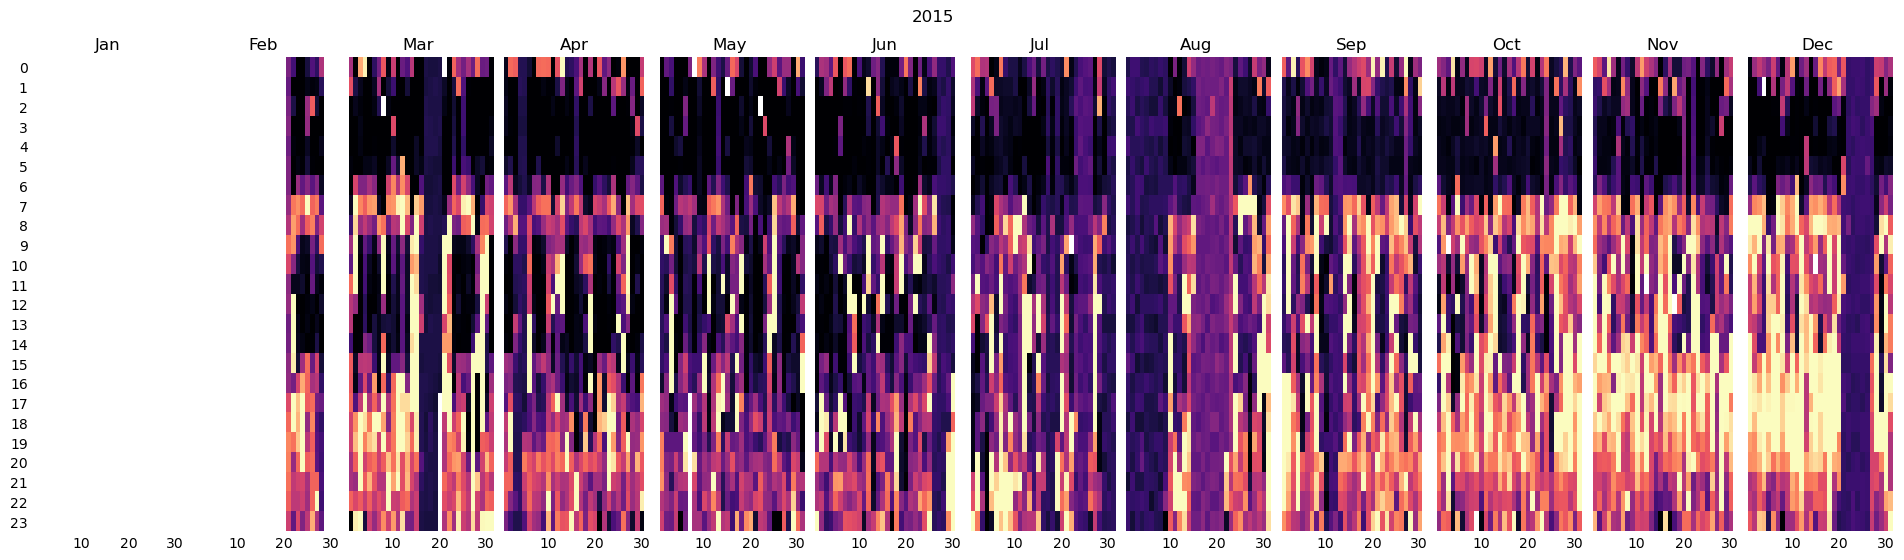

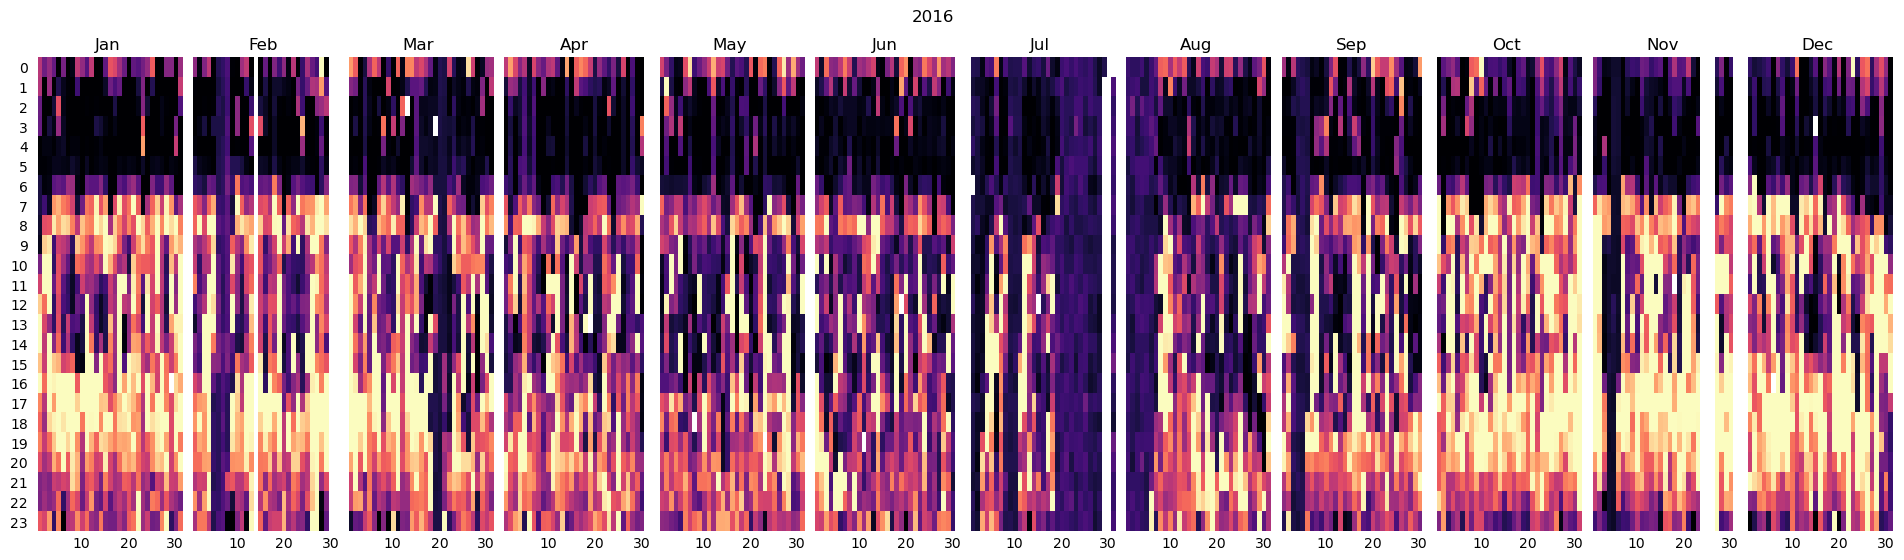

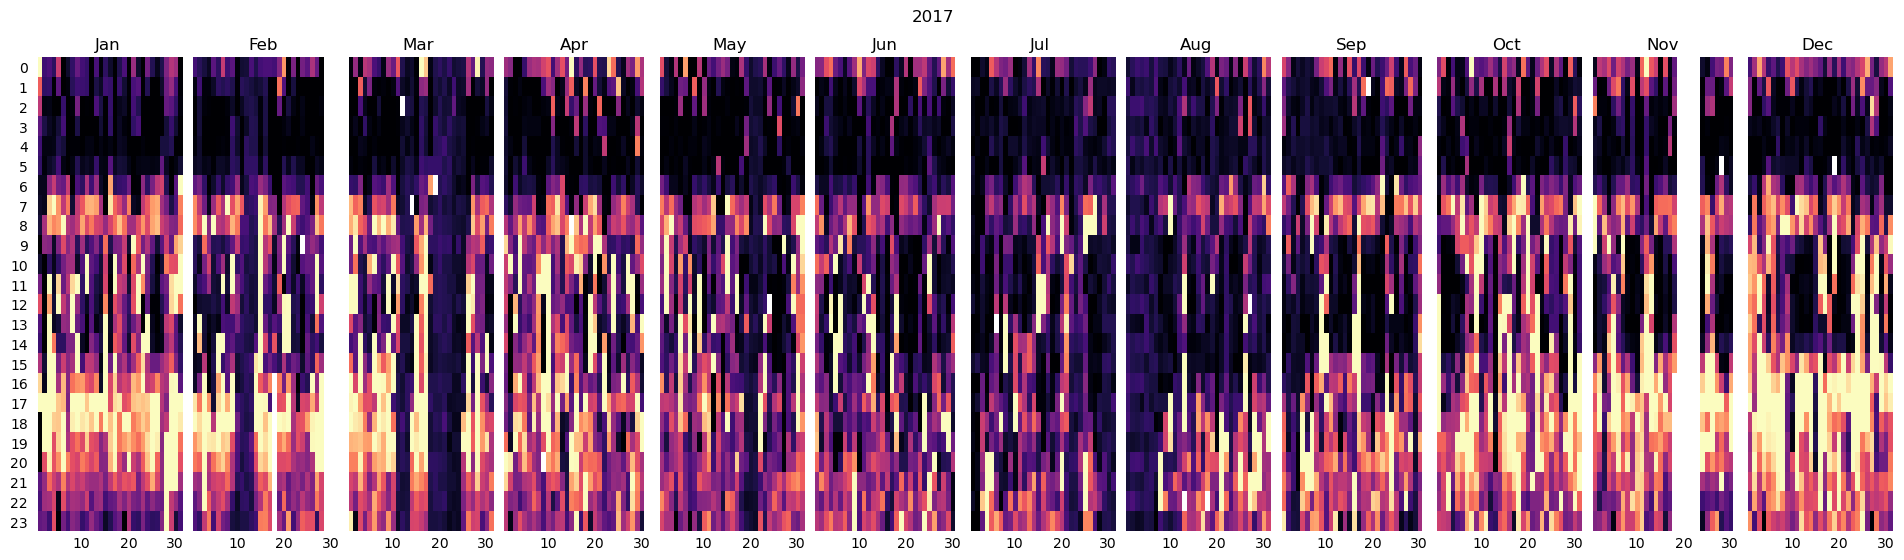

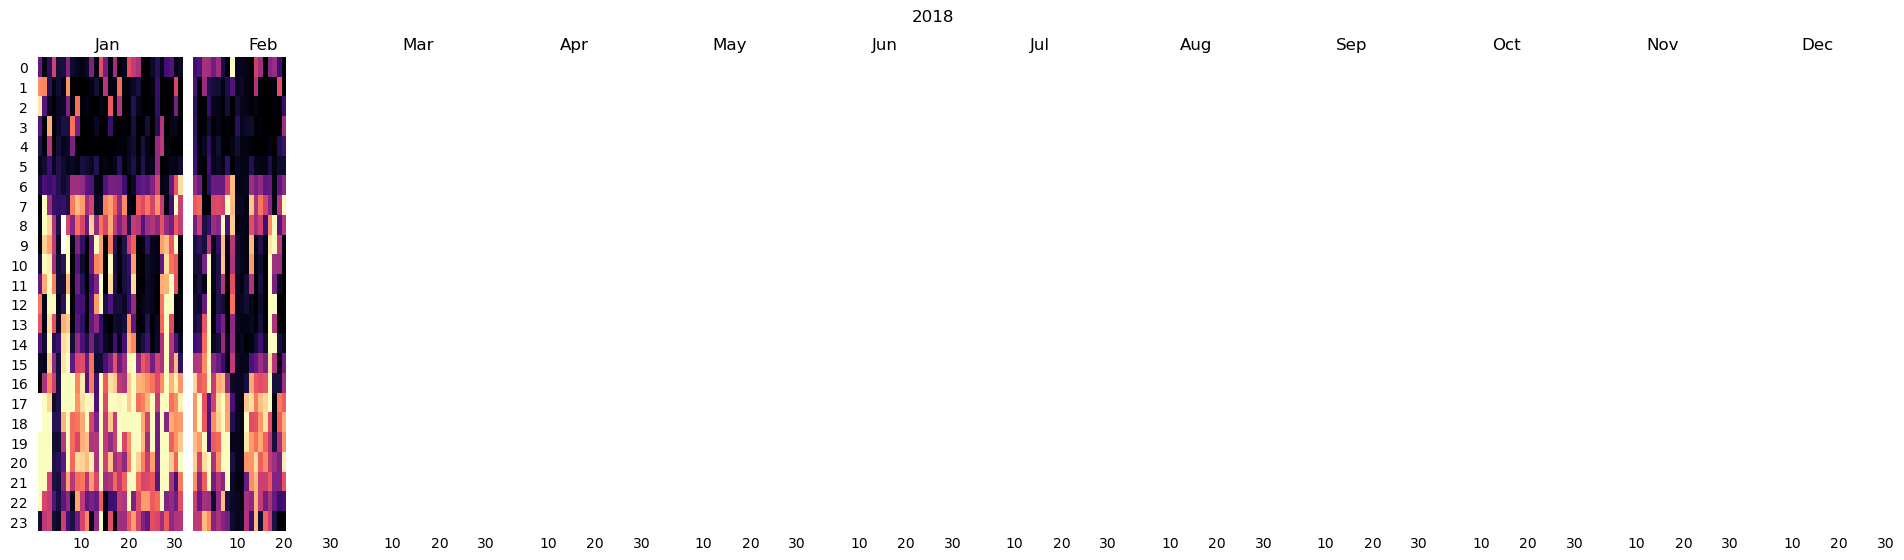

In [4]:
key = 'energy'

view = df[df.residential_id == 8]
view = view.set_index('timestamp').sort_index()

vmin, vmax = view[key].quantile(0.1), view[key].quantile(0.9)

months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')

for i, year in enumerate(view.index.year.unique()):
    fig, axes = plt.subplots(ncols=12, figsize=(20, 6), sharey=True)

    fig.suptitle(year)
    for j, month in enumerate(range(1, 13)):
        monthly_plot(view, key, month, year, axes[j], vmin, vmax)

        axes[j].set_title(months[j])

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)
    plt.show()

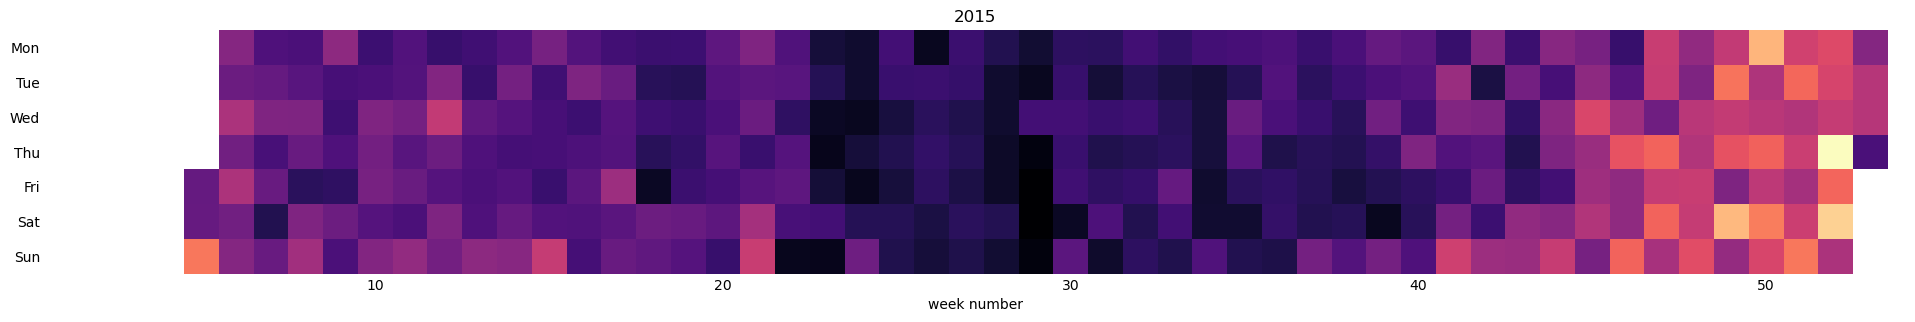

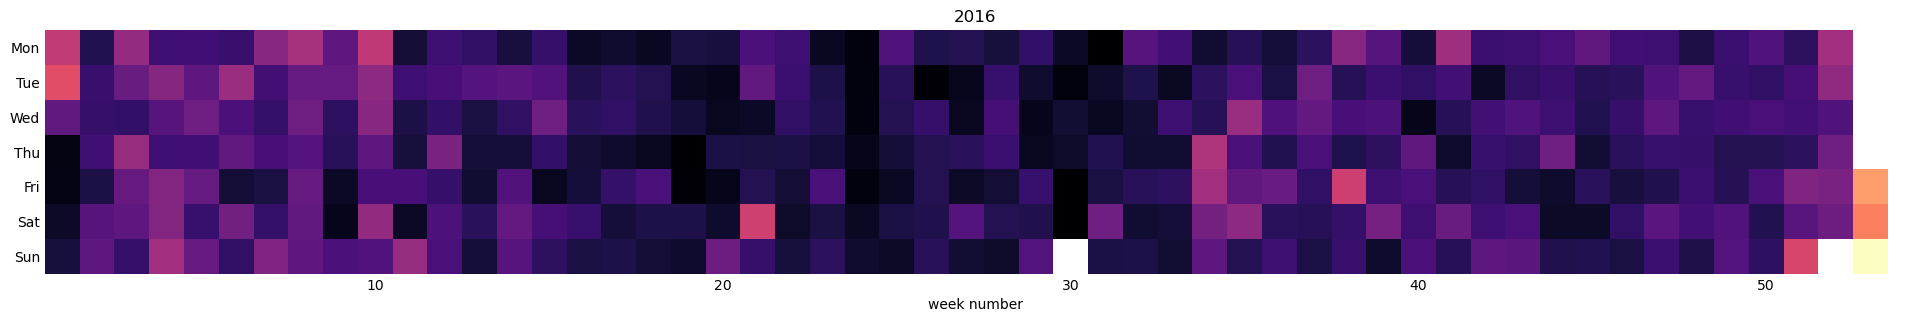

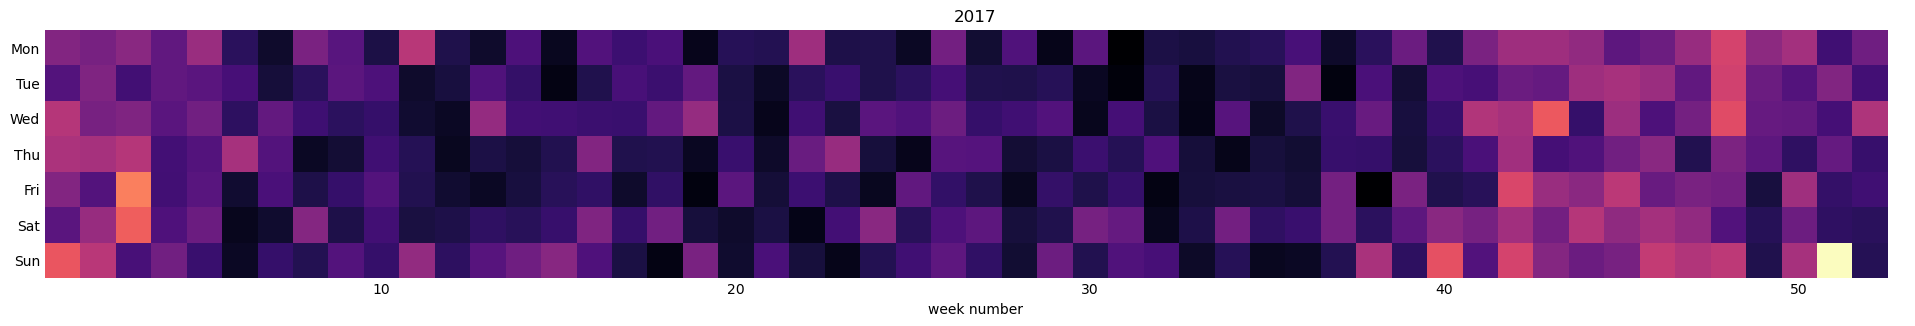

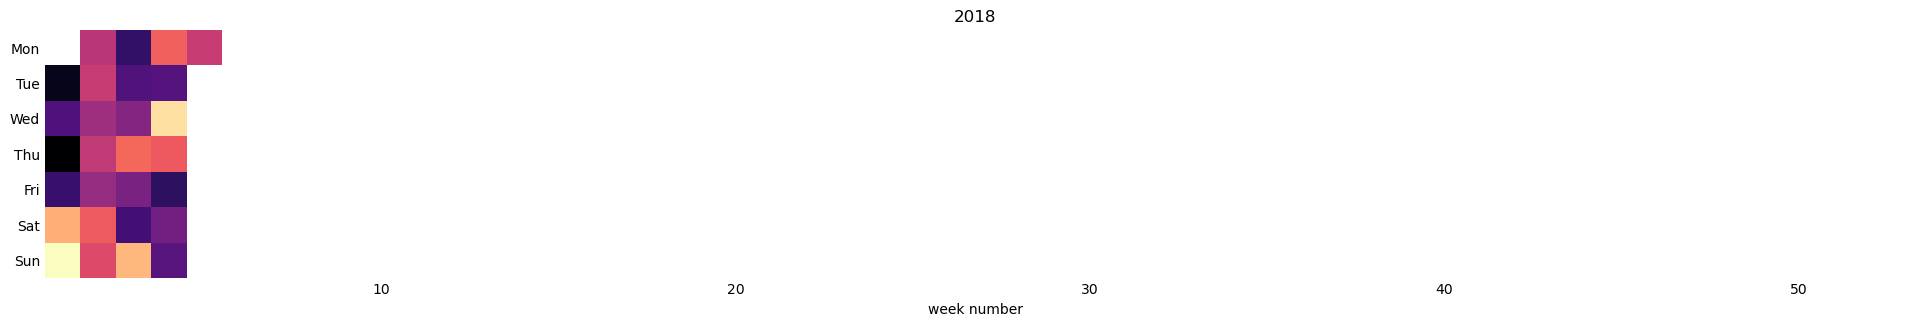

In [5]:
key = 'energy'
view = df[df.residential_id == 5]
years = view.timestamp.dt.year.unique()

# Fix this two lines to your needs. You must end up with DateTimeIndex and value with daily sampling
view = view.set_index('timestamp')
view = view[[key]].resample('1D').mean()


for i, year in enumerate(years):
    fig, axes = plt.subplots(figsize=(20, 6))
    weekly_plot(view, key, year, axes)

    axes.set_title(year)

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, hspace=0.08, wspace=0.04)
    plt.show()


In [6]:
#df.dropna(inplace=True)
#df.reset_index(drop=True, inplace=True)

# convert Wh --> kWh
df['energy'] = df['energy'] / 1000.0

df['house_activity'] = False

for _, group in df.groupby(by='residential_id'):
    group = group.sort_values(by='timestamp')

    for col in ['energy']:
        df.loc[group.index, f'{col}_mean_3h'] = group[col].rolling(3).mean()
        df.loc[group.index, f'{col}_std_3h'] = group[col].rolling(3).std()

    df.loc[group.index, 'prediction_1h_ahead'] = group['energy'].shift(-1)
    df.loc[group.index, 'prediction_3h_ahead'] = group['energy'].rolling(3).sum().shift(-3)


    # Energy spent today (don't use because it leaks data. Discard after done.)
    for _, subgroup in df.groupby(group.timestamp.dt.date):
        df.loc[subgroup.index, 'daily_ratio'] = subgroup['energy'] / subgroup['energy'].sum()

        df.loc[subgroup.index, 'today_median_energy'] = subgroup['energy'].median()

    
    # energy consumption 1 day ago, 1 week ago
    df.loc[group.index,'yesterday_ratio'] = df.loc[group.index,'daily_ratio'].shift(24)
    df.loc[group.index,'yesterday_ratio_ahead'] = df.loc[group.index,'daily_ratio'].shift(24 - 1)

    df.loc[group.index,'last_week_ratio'] = df.loc[group.index,'daily_ratio'].shift(24 * 7)
    df.loc[group.index,'last_week_ratio_ahead'] = df.loc[group.index,'daily_ratio'].shift(24 * 7 - 1)


    # Estimate activity through median value of the time-series
    #group['house_activity'] = group.energy >= group.energy.median()
    df.loc[group.index, 'yesterday_median_energy'] = df.loc[group.index, 'today_median_energy'].shift(24)

    df.loc[group.index, 'energy_yesterday'] = group['energy'].shift(24)
    df.loc[group.index, 'energy_yesterday_ahead'] = group['energy'].shift(24 - 1)

    df.loc[group.index, 'energy_last_week'] = group['energy'].shift(24 * 7)
    df.loc[group.index, 'energy_last_week_ahead'] = group['energy'].shift(24 * 7 - 1)

    df.loc[group.index, 'house_activity'] = df.loc[group.index, 'energy'] >= df.loc[group.index, 'yesterday_median_energy']


# Behavioral features based on hour ranges
# 6 - 9 breakfast
df['breakfast_6_9'] = (df.timestamp.dt.hour >= 6) & (df.timestamp.dt.hour < 9)
# 11 - 16 lunch
df['lunch_11_15'] = (df.timestamp.dt.hour >= 11) & (df.timestamp.dt.hour < 15)
# 18 - 21 dinner
df['dinner_18_21'] = (df.timestamp.dt.hour >= 18) & (df.timestamp.dt.hour < 21)
# 22 - 7 sleep
df['sleep_22_7'] = (df.timestamp.dt.hour >= 22) | (df.timestamp.dt.hour <= 6)
# 9 - 17 work hours
df['work_9_17'] = (df.timestamp.dt.hour >= 9) & (df.timestamp.dt.hour < 17)

df['freetime_17_22'] = (df.timestamp.dt.hour >= 17) & (df.timestamp.dt.hour < 22)

# Is daylight saving time
df['is_dst'] = df.timestamp.map(lambda x : int(x.dst().total_seconds() != 0)).astype(bool)


df.drop(columns=['daily_ratio', 'today_median_energy'], inplace=True)

In [7]:
list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")

df['residential_id'] = df['residential_id'].astype("category")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592618 entries, 0 to 592620
Data columns (total 58 columns):
 #   Column                   Non-Null Count   Dtype                         
---  ------                   --------------   -----                         
 0   timestamp                592618 non-null  datetime64[ns, Canada/Pacific]
 1   residential_id           592618 non-null  category                      
 2   energy                   587649 non-null  float64                       
 3   house_type               592618 non-null  category                      
 4   facing                   592618 non-null  category                      
 5   region                   592618 non-null  category                      
 6   RUs                      592618 non-null  float64                       
 7   EVs                      592618 non-null  float64                       
 8   SN                       592618 non-null  float64                       
 9   FAGF                     5

In [8]:
df.tail().T

,592616,592617,592618,592619,592620
timestamp,2018-03-25 19:00:00-07:00,2018-03-25 20:00:00-07:00,2018-03-25 21:00:00-07:00,2018-03-25 22:00:00-07:00,2018-03-25 23:00:00-07:00
residential_id,19,19,19,19,19
energy,2.05,1.99,2.12,2.2,1.89
house_type,special,special,special,special,special
facing,W,W,W,W,W
region,YVR,YVR,YVR,YVR,YVR
RUs,0.0,0.0,0.0,0.0,0.0
EVs,0.0,0.0,0.0,0.0,0.0
SN,0.0,0.0,0.0,0.0,0.0
FAGF,1,1,1,1,1


In [9]:
from pprint import pprint

domain_features = {
    'EVs': ['EVs'],
    'measurements': [c for c in df.columns if c.startswith('energy')],
}
print('\n== Domain Specific Features ==')
pprint(domain_features)

contextual_features = {
    'geolocation': ['lat', 'lon', 'region', 'country', 'residential_id'],
    'time': [name for name in df.columns if name.startswith('year_') or name.startswith('day_') or name.startswith('week_')] + ['timestamp', 'tz', 'is_dst'],
    'weather_conditions': ['temperature', 'humidity', 'pressure', 'solar_altitude', 'solar_azimuth', 'solar_radiation'],
    'building_properties': ['house_type', 'facing'] + ['RUs', 'SN', 'FAGF', 'HP', 'FPG', 'FPE', 'IFRHG', 'NAC', 'FAC', 'PAC', 'BHE', 'IFRHE', 'WRHIR', 'GEOTH'],
}
print('\n== Contextual Features ==')
pprint(contextual_features)

behavioral_features = {
    'social_activities': ['weekday', 'is_holiday', 'is_weekend'],
    #'cooking': ['kitchen_activity'],
    'work_schedule': [
        'yesterday_ratio', 'yesterday_ratio_ahead', 'last_week_ratio', 'last_week_ratio_ahead', 'yesterday_median_energy', 'house_activity',
        'breakfast_6_9', 'dinner_18_21', 'freetime_17_22', 'lunch_11_15', 'sleep_22_7', 'work_9_17',
    ],
}
print('\n== Behavioral Features ==')
pprint(behavioral_features)


#domain_features = ['EVs'] + [c for c in df.columns if c.startswith('energy')]
#contextual_features = [
#    'residential_id', 'house_type', 'facing', 'region', 'RUs', 'SN', 'FAGF', 'HP', 'FPG', 'FPE', 'IFRHG',
#    'NAC', 'FAC', 'PAC', 'BHE', 'IFRHE', 'WRHIR', 'GEOTH', 'country', 'lat', 'lon', 'tz', 'temperature', 'humidity', 'pressure',
#    'day_percent', 'week_percent', 'year_percent', 'solar_altitude', 'solar_azimuth', 'solar_radiation'
#]
#behavioral_features = ['weekday', 'is_weekend', 'is_holiday', 'house_activity', 'yesterday_ratio', 'yesterday_ahead_ratio', 'last_week_ratio', 'last_week_ahead_ratio', 'yesterday_median_energy']

obtained_features = (
    [x for v in domain_features.values() for x in v] +
    [x for v in contextual_features.values() for x in v] +
    [x for v in behavioral_features.values() for x in v] +
    #["tz", 'region', "country", "timestamp"] + # useless in our case because it is constant
    ['prediction_1h_ahead', 'prediction_3h_ahead']
)

# Check for missed features #1, #2, and duplicates
set(df.columns) - set(obtained_features), set(obtained_features) - set(df.columns), set([x for x in obtained_features if obtained_features.count(x) > 1])


== Domain Specific Features ==
{'EVs': ['EVs'],
 'measurements': ['energy',
                  'energy_mean_3h',
                  'energy_std_3h',
                  'energy_yesterday',
                  'energy_yesterday_ahead',
                  'energy_last_week',
                  'energy_last_week_ahead']}

== Contextual Features ==
{'building_properties': ['house_type',
                         'facing',
                         'RUs',
                         'SN',
                         'FAGF',
                         'HP',
                         'FPG',
                         'FPE',
                         'IFRHG',
                         'NAC',
                         'FAC',
                         'PAC',
                         'BHE',
                         'IFRHE',
                         'WRHIR',
                         'GEOTH'],
 'geolocation': ['lat', 'lon', 'region', 'country', 'residential_id'],
 'time': ['day_percent',
          'week_percent',
        

(set(), set(), set())

In [10]:
domain_features = [x for v in domain_features.values() for x in v]
contextual_features = [x for v in contextual_features.values() for x in v]
behavioral_features = [x for v in behavioral_features.values() for x in v]

In [11]:
df.to_parquet('../../data/hue-dataset-hourly.complete.parquet')

In [23]:
from sklearn import ensemble, tree, model_selection, compose, feature_selection, neural_network, pipeline, metrics, linear_model
from joblib import Memory
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer


def mean_percentage_error(A, F):
    #A_abs, F_abs = np.abs(A), np.abs(F)
    #mask = ~(np.maximum(A_abs, F_abs) == 0)
    top = np.abs(A - F)
    bottom = np.maximum(np.maximum(np.abs(A), np.abs(F)), np.finfo(float).eps)
    return 100.0 * np.mean(top / bottom)


mapper = make_column_transformer(
    ('drop', make_column_selector(dtype_include=['datetime', 'datetimetz'])),
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=['category', 'object'])),
    n_jobs=-1,
    remainder='passthrough',
    verbose=False,
    verbose_feature_names_out=False
).set_output(transform='pandas')

model = pipeline.make_pipeline(
    mapper,
    #linear_model.LinearRegression(n_jobs=-1),
    #xgb.XGBRegressor(n_jobs=-1, random_state=42),
    neural_network.MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, learning_rate='adaptive', random_state=42),
    verbose=False,
)

prediction = 'prediction_1h_ahead'

used_features = []

#used_features = ['energy']

used_features += domain_features
used_features += contextual_features
used_features += behavioral_features


X_train, X_test, y_train, y_test = [], [], [], []

for _, group in df.groupby(by='residential_id'):

    _group = df.loc[group.index, [prediction, *used_features]].copy().dropna()

    _X_train, _X_test, _y_train, _y_test = model_selection.train_test_split(_group[used_features], _group[prediction], train_size=0.8, shuffle=False)

    X_train.append(_X_train)
    X_test.append(_X_test)
    y_train.append(_y_train)
    y_test.append(_y_test)

X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

print(f'# samples: {len(X_train):,} :: {len(X_train) / (len(df) // 0.8) * 100:,.3f}%')

#X_train, X_test, y_train, y_test = model_selection.train_test_split(X[used_features], y, train_size=0.8, shuffle=False)
#y_pred = model_selection.cross_val_predict(model, X, y, cv=model_selection.KFold(n_splits=10, shuffle=True, random_state=42), n_jobs=1)
y_pred = model.fit(X_train, y_train).predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred)
mpe = mean_percentage_error(y_test, y_pred)

print(f'& {mse:,.3f} & {mpe:,.3f}  % 2023-04-20 -- MLP')

# samples: 456,177 :: 61.581%
& 0.519 & 62.659  % 2023-04-20 -- MLP


In [12]:
import shap
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import LabelEncoder

mapper = make_column_transformer(
    ('drop', make_column_selector(dtype_include=['datetime', 'datetimetz'])),
    (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=['category', 'object'])),
    n_jobs=-1,
    remainder='passthrough',
    verbose=True,
    verbose_feature_names_out=False
).set_output(transform='pandas')


_df = df[[prediction, *used_features]].copy().dropna()
X, y = _df[used_features], _df[prediction]
_X = mapper.fit_transform(X)

# Rename columns to to show what group in belongs
rename = {}
for col in _X.columns:
    for sample in domain_features:
        if col.startswith(sample):
            rename[col] = f'{col} (D)'

    for sample in contextual_features:
        if col.startswith(sample):
            rename[col] = f'{col} (C)'

    for sample in behavioral_features:
        if col.startswith(sample):
            rename[col] = f'{col} (B)'

_X.rename(columns=rename, inplace=True)

#print(_X.dtypes)

#model = ensemble.RandomForestRegressor(min_samples_leaf=10, n_jobs=8, random_state=42)
model = xgb.XGBRegressor(n_jobs=-1, random_state=42)
model.fit(_X, y)

[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[ColumnTransformer] . (1 of 2) Processing onehotencoder, total=   0.4s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [13]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(_X)
#clustering = shap.utils.hclust(_X, y)

{'D': 8, 'C': 74, 'B': 15} 97


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
invalid value encountered in log10
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


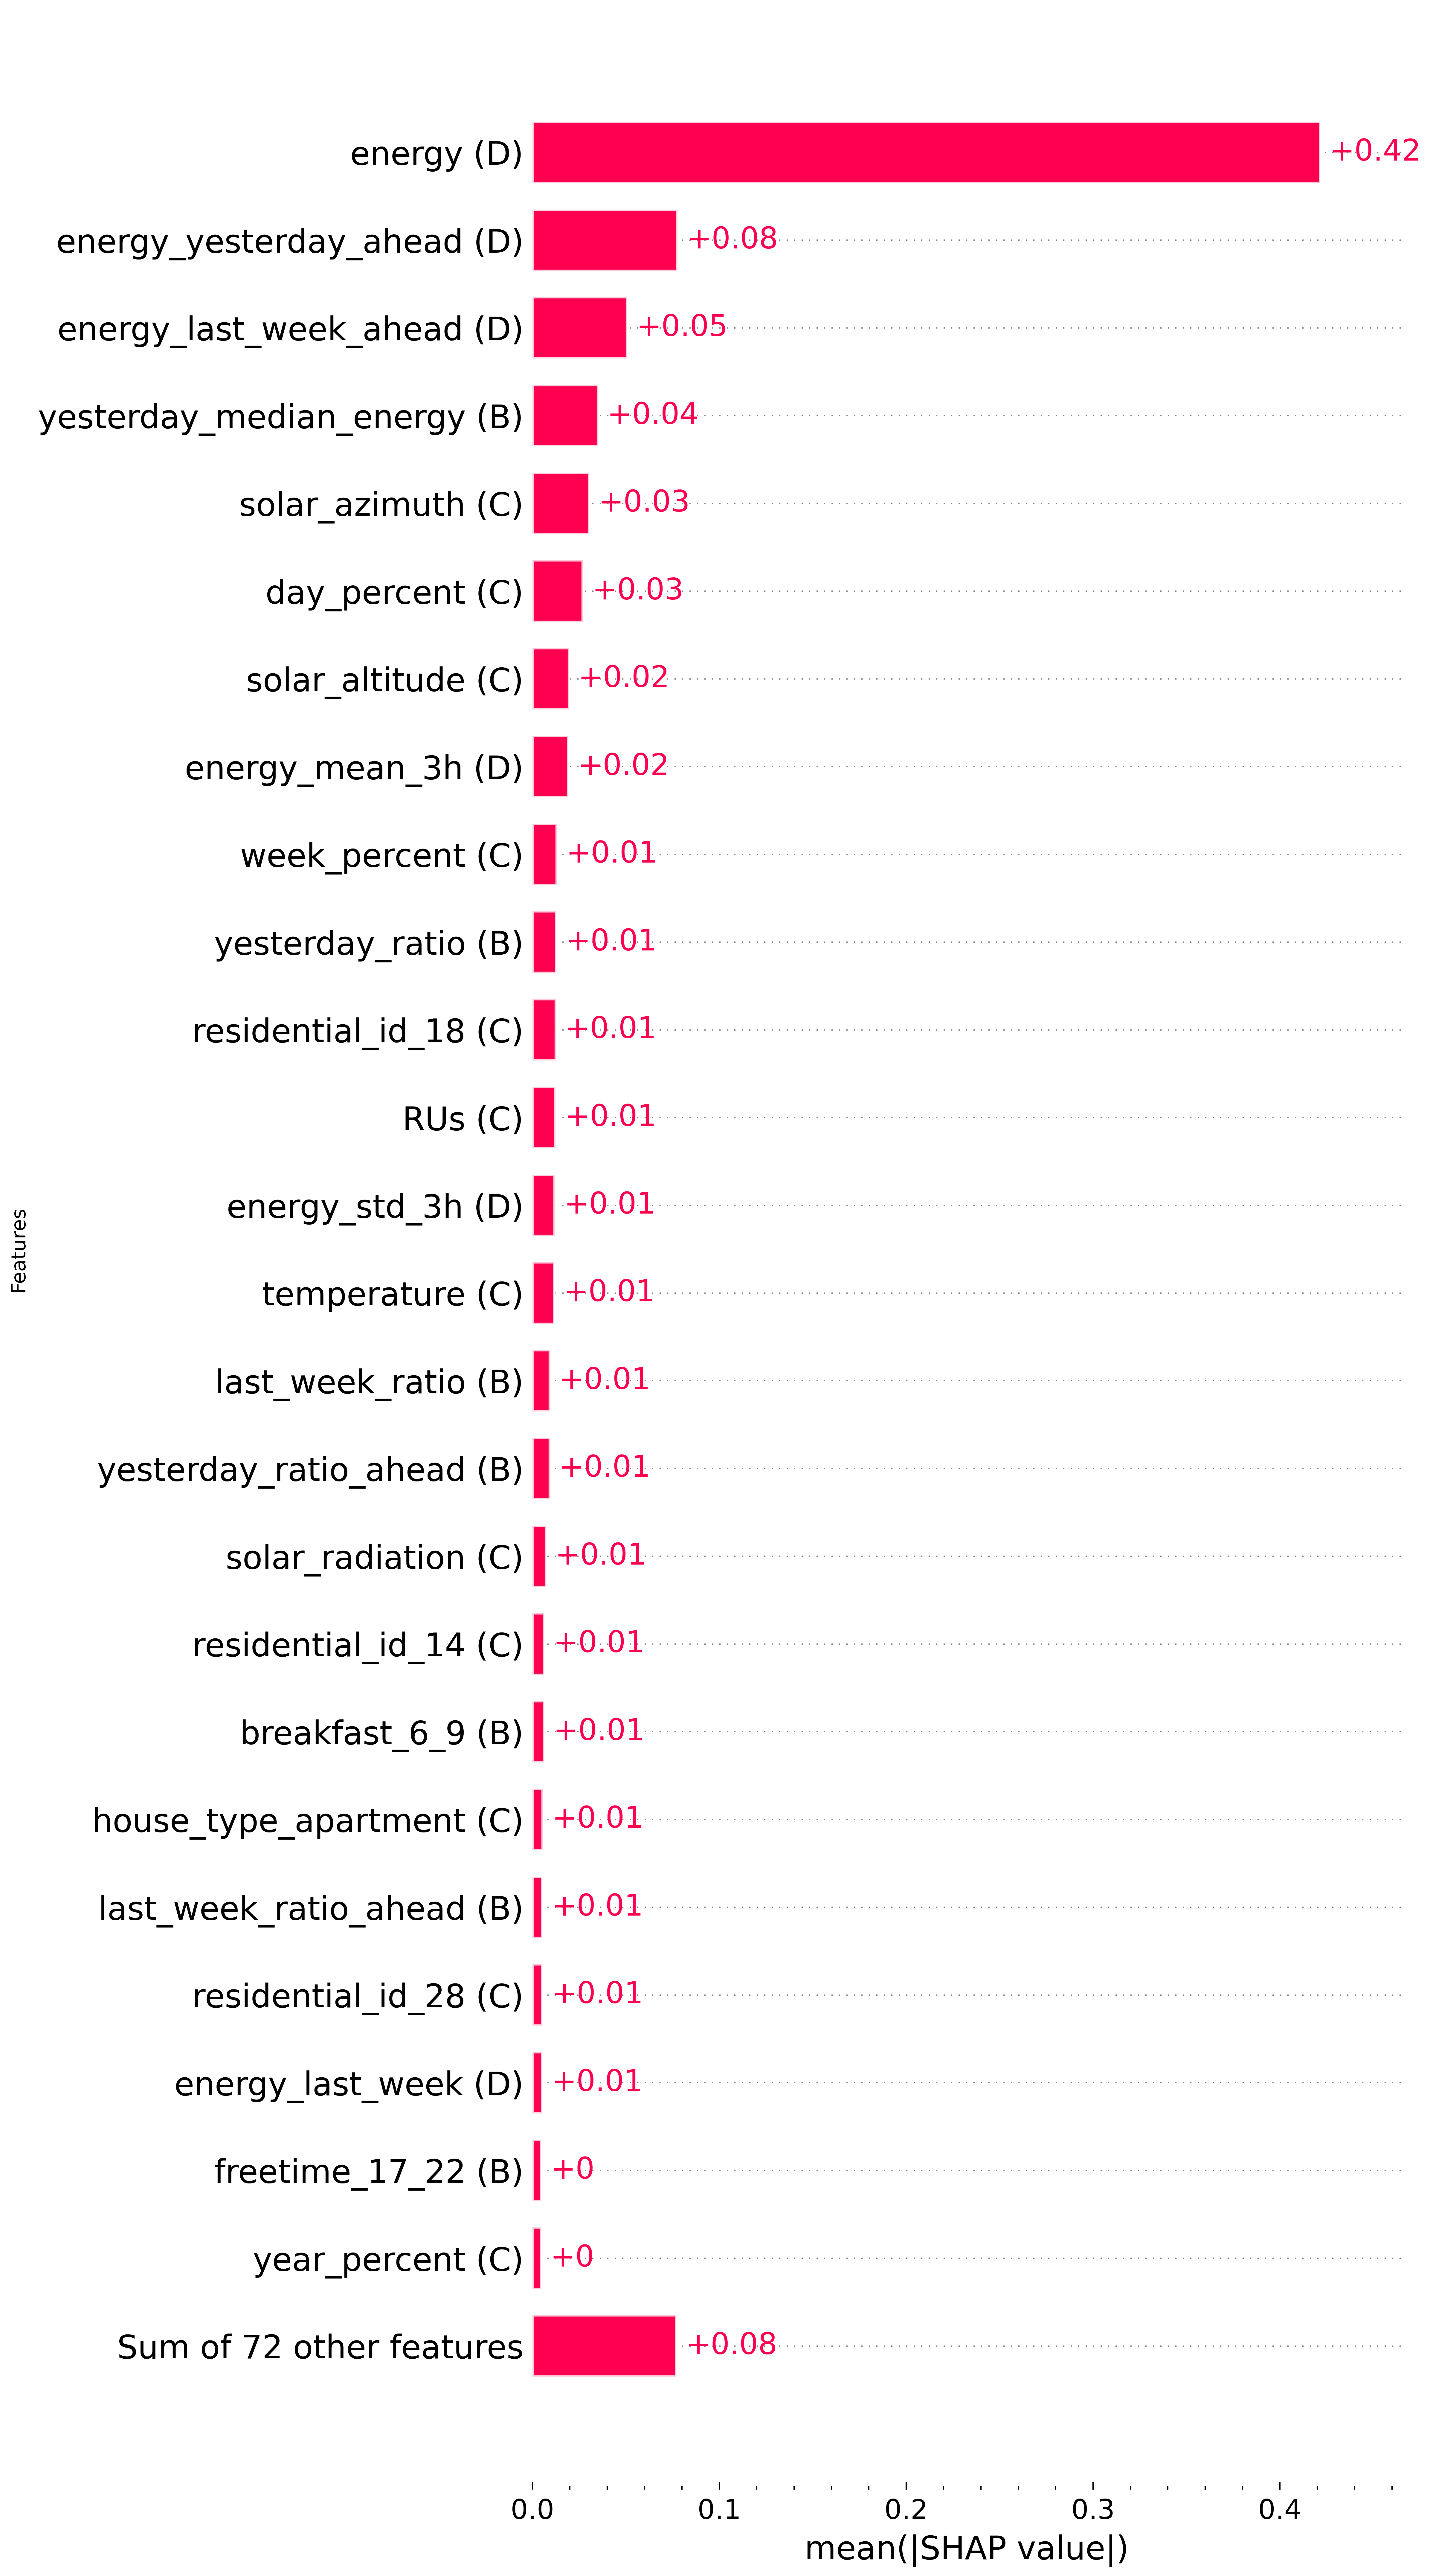

In [14]:
count = {'D': 0, 'C': 0, 'B': 0}
for feature in _X.columns:
    if feature.endswith('(D)'):
        count['D'] += 1
    elif feature.endswith('(C)'):
        count['C'] += 1
    elif feature.endswith('(B)'):
        count['B'] += 1

print(count, len(_X.columns))

plt.rcdefaults()
plt.style.use(['science', 'ieee', 'no-latex'])

# visualize all the training set predictions


shap.plots.bar(
    shap_values,
    max_display=25+1, #len(_X.columns),
    show=False,
)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(False)
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [15]:
total_sum = {'D': 0, 'C': 0, 'B': 0}
count = {'D': 0, 'C': 0, 'B': 0}

for feature, value in zip(_X.columns, np.mean(np.abs(shap_values.values), axis=0)):
    if feature.endswith('(D)'):
        total_sum['D'] += value
        count['D'] += 1

    elif feature.endswith('(C)'):
        total_sum['C'] += value
        count['C'] += 1

    elif feature.endswith('(B)'):
        total_sum['B'] += value
        count['B'] += 1

    #if value > 0.41:
    #    print(feature, value)

# Normalize
average = { key: (total_sum[key] / count[key]) for key in ['D', 'C', 'B'] }

print(count, sum(count.values()))
print(total_sum)
print(average)

{'D': 8, 'C': 74, 'B': 15} 97
{'D': 0.5904172165319324, 'C': 0.21316403806849848, 'B': 0.0983587236260064}
{'D': 0.07380215206649154, 'C': 0.0028805951090337635, 'B': 0.00655724824173376}


In [ ]:
from sklearn.feature_selection import r_regression

prediction_cols = ['prediction_1h_ahead', 'prediction_3h_ahead']

_df = df[[*(domain_features+contextual_features+behavioral_features), *prediction_cols]].copy().dropna()
_df = mapper.fit_transform(_df)
_df.rename(columns=rename, inplace=True)


corr_avg = {'D': 0, 'B': 0, 'C': 0}
count = {'D': 0, 'B': 0, 'C': 0}

for col in _df.columns:
    score = np.abs(r_regression(_df[[col]], _df[['prediction_1h_ahead']]))
    if np.isinf(score):
        print(f"Skip {col}")
        continue


    if col.endswith('(D)'):
        corr_avg['D'] += score
        count['D'] += 1

    elif col.endswith('(C)'):
        corr_avg['C'] += score
        count['C'] += 1

    elif col.endswith('(B)'):
        corr_avg['B'] += score
        count['B'] += 1

print({ k: (corr_avg[k] / count[k]) for k in count.keys() })


#data_cols = list(filter(lambda x: x.startswith('prediction') or x.endswith('(C)'), _df.columns))
#_df = _df[data_cols]

f = plt.figure(figsize=(19, 19))
plt.matshow(_df.corr(), fignum=f.number, interpolation='none', cmap='bwr')
plt.xticks(range(_df.shape[1]), _df.columns, fontsize=10, rotation=90)
plt.yticks(range(_df.shape[1]), _df.columns, fontsize=10)
plt.grid(False)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
def evaluation(df:pd.DataFrame, households:list, prediction='prediction_1h_ahead', used_features=domain_features+contextual_features+behavioral_features):
    mapper = make_column_transformer(
        ('drop', make_column_selector(dtype_include=['datetime64[ns]'])),
        (OneHotEncoder(sparse_output=False), make_column_selector(dtype_include=['category', 'object'])),
        n_jobs=-1,
        remainder='passthrough',
        verbose=False,
        verbose_feature_names_out=False
    )
    mapper.set_output(transform='pandas')


    X_train, X_test, y_train, y_test = [], [], [], []

    df = df.loc[df['residential_id'].isin(households)]

    for _, group in df.groupby(by='residential_id'):

        _group = df.loc[group.index, [prediction, *used_features]].copy().dropna()

        _X_train, _X_test, _y_train, _y_test = model_selection.train_test_split(_group[used_features], _group[prediction], train_size=0.8, shuffle=False)

        X_train.append(_X_train)
        X_test.append(_X_test)
        y_train.append(_y_train)
        y_test.append(_y_test)

    X_train = pd.concat(X_train)
    X_test = pd.concat(X_test)
    y_train = pd.concat(y_train)
    y_test = pd.concat(y_test)


    mapper.fit(X_train)
    X_train = mapper.transform(X_train)
    X_test = mapper.transform(X_test)


    # Rename columns to to show what group in belongs
    rename = {}
    for col in X_train.columns:
        for sample in domain_features:
            if col.startswith(sample):
                rename[col] = f'{col} (D)'

        for sample in contextual_features:
            if col.startswith(sample):
                rename[col] = f'{col} (C)'

        for sample in behavioral_features:
            if col.startswith(sample):
                rename[col] = f'{col} (B)'

    X_train.rename(columns=rename, inplace=True)
    X_test.rename(columns=rename, inplace=True)


    model = xgb.XGBRegressor(n_jobs=-1, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)


    mape = metrics.mean_absolute_percentage_error(y_test + 1e-6, y_pred + 1e-6)
    mse = metrics.mean_squared_error(y_test, y_pred)

    #shap_avg = np.mean(np.abs(shap_values.values), axis=0)

    # Statistics
    n_features = {'D': 0, 'C': 0, 'B': 0}
    contributions = {'D': 0, 'C': 0, 'B': 0}

    for feature, value in zip(X_train.columns, np.mean(np.abs(shap_values.values), axis=0)):
        if feature.endswith('(D)'):
            contributions['D'] += value
            n_features['D'] += 1

        elif feature.endswith('(C)'):
            contributions['C'] += value
            n_features['C'] += 1

        elif feature.endswith('(B)'):
            contributions['B'] += value
            n_features['B'] += 1

        #if value > 0.41:
        #    print(feature, value)

    # Normalize
    norm_contributions = { key: (total_sum[key] / count[key]) for key in ['D', 'C', 'B'] }

    return dict(
        households=households,
        n_households=len(households),
        mape=mape,
        mse=mse,
        all_features=sum(count.values()),
        n_features=n_features,
        contributions=contributions,
        norm_contributions=norm_contributions,
    )

import itertools as it
houses = list(df['residential_id'].unique())
combinations = []
#for n in range(len(houses) + 1):
#    combinations += list(it.combinations(houses, n))
rng = np.random.default_rng(seed=42)
combinations = [rng.choice(houses, i) for i in range(1, len(houses) + 1)]

results = []
for combination in combinations:
    if len(combination) == 0:
        continue

    print(len(combination), combination)
    result = evaluation(df, households=list(combination))
    results.append(result)

In [ ]:
x = list(map(lambda x: x['norm_contributions'], results))
d, c, b = map(lambda t: t['D'], x), map(lambda t: t['C'], x), map(lambda t: t['B'], x)

n = list(map(lambda x: x['n_households'], results))

plt.plot(n, list(d), label='Domain')
plt.plot(n, list(c), label='Contextual')
plt.plot(n, list(b), label='Behavioral')
plt.xlim(1, None)
plt.yscale('log')
plt.legend()
plt.xlabel('number of used households')
plt.ylabel('Cumulative SHAP score')
plt.show()


x = list(map(lambda x: x['mse'], results))
plt.plot(n, x)
plt.xlim(1, None)
plt.xlabel('number of used households')
plt.ylabel('MSE')
plt.show()

x = list(map(lambda x: x['mape'], results))
plt.plot(n, x)
plt.xlim(1, None)
plt.xlabel('number of used households')
plt.ylabel('MAPE')

In [ ]:



# https://stackoverflow.com/a/44513347

In [35]:
import logging
import warnings

from sklearn.compose import make_column_selector, make_column_transformer
from prophet import Prophet

logging.getLogger('cmdstanpy').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

used_features = []

#used_features = ['energy']

used_features += domain_features
used_features += contextual_features
used_features += behavioral_features

prediction = 'prediction_1h_ahead'


for col in ('tz', 'country', 'timestamp'):
    if col in used_features:
        used_features.remove(col)


mapper = make_column_transformer(
    #('drop', ["tz", "country", 'timestamp']),
    (OneHotEncoder(sparse_output=False, drop='if_binary'), make_column_selector(dtype_include=['category', 'object'])),
    remainder='passthrough',
    n_jobs=8,
    verbose=False,
    verbose_feature_names_out=False
).set_output(transform='pandas')


_df = df.copy()
_df.timestamp = _df.timestamp.dt.tz_localize(None)

y_test, y_pred = [], []
for _, group in _df.groupby(by='residential_id'):
    dfp = group[['timestamp', prediction, *used_features]].copy().reset_index(drop=True).dropna()
    dfp.rename(columns={'timestamp': 'ds', prediction: 'y'}, inplace=True, errors='raise')

    dfp_train, dfp_test = model_selection.train_test_split(dfp, train_size=0.8, shuffle=False)

    mapper.fit(dfp_train)
    dfp_train = mapper.transform(dfp_train)
    dfp_test = mapper.transform(dfp_test)

    m = Prophet()

    if 'is_holiday' in used_features:
        print('Holidays enabled')
        m.add_country_holidays(country_name='Canada')

    for f in mapper.get_feature_names_out():
        if f not in ('ds', 'y'):
            m.add_regressor(f)

    forecast = m.fit(dfp_train).predict(dfp_test)

    y_test.append(dfp_test['y'])
    y_pred.append(forecast['yhat'])



y_test = pd.concat(y_test, ignore_index=True).to_numpy()
y_pred = pd.concat(y_pred, ignore_index=True).to_numpy()

mse = metrics.mean_squared_error(y_test, y_pred)
mpe = mean_percentage_error(y_test, y_pred)

print(f'& {mse:,.3f} & {mpe:,.3f}  % 2023-04-20 -- Prophet')

Holidays enabled


10:58:31 - cmdstanpy - INFO - Chain [1] start processing
10:58:40 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


10:58:43 - cmdstanpy - INFO - Chain [1] start processing
10:58:48 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


10:58:51 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


10:59:03 - cmdstanpy - INFO - Chain [1] start processing
10:59:11 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


10:59:14 - cmdstanpy - INFO - Chain [1] start processing
10:59:22 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


10:59:25 - cmdstanpy - INFO - Chain [1] start processing
10:59:32 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


10:59:35 - cmdstanpy - INFO - Chain [1] start processing
10:59:42 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


10:59:44 - cmdstanpy - INFO - Chain [1] start processing
10:59:50 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


10:59:52 - cmdstanpy - INFO - Chain [1] start processing
11:00:01 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:00:04 - cmdstanpy - INFO - Chain [1] start processing
11:00:09 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:00:12 - cmdstanpy - INFO - Chain [1] start processing
11:00:21 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:00:24 - cmdstanpy - INFO - Chain [1] start processing
11:00:33 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:43 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:00:46 - cmdstanpy - INFO - Chain [1] start processing
11:00:48 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:00:50 - cmdstanpy - INFO - Chain [1] start processing
11:00:51 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:00:52 - cmdstanpy - INFO - Chain [1] start processing
11:00:53 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:00:56 - cmdstanpy - INFO - Chain [1] start processing
11:01:02 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:01:04 - cmdstanpy - INFO - Chain [1] start processing
11:01:12 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:01:15 - cmdstanpy - INFO - Chain [1] start processing
11:01:22 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:01:23 - cmdstanpy - INFO - Chain [1] start processing
11:01:23 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:01:25 - cmdstanpy - INFO - Chain [1] start processing
11:01:27 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:01:30 - cmdstanpy - INFO - Chain [1] start processing
11:01:36 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:01:39 - cmdstanpy - INFO - Chain [1] start processing
11:01:48 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:01:51 - cmdstanpy - INFO - Chain [1] start processing
11:01:58 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:02:00 - cmdstanpy - INFO - Chain [1] start processing
11:02:00 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:02:01 - cmdstanpy - INFO - Chain [1] start processing
11:02:03 - cmdstanpy - INFO - Chain [1] done processing


Holidays enabled


11:02:04 - cmdstanpy - INFO - Chain [1] start processing
11:02:06 - cmdstanpy - INFO - Chain [1] done processing


& 0.320 & 28.034  % 2023-04-20 -- Prophet
